# Grab the vertices of the glacier terminus boxes in pixel coordinates

### Jukes Liu

The vertices of the glacier terminus box will be used to calculate a midpoint of the left edge of the terminus box, which will be our reference point for calculating terminus position.

### Import packages, set basepath, grab BoxIDs for terminus boxes

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

basepath = '/home/jukes/Documents/Sample_glaciers/'

In [14]:
#grab the BoxIDs
# pathrows_df = pd.read_csv(basepath+'LS_pathrows.csv', sep=',', usecols =[0,1,2], dtype=str, nrows =10)
# pathrows_df = pathrows_df.set_index('BoxID')
# BoxIDs = pathrows_df.index
# pathrows_df
BoxIDs = ['Alison', 'Helheim']

### Read in terminus box rasters and perform a visual check

In [8]:
#create dictionary to store each terminus box ndarray by BoxID
termboxes = {}

#read in the terminus box rasters
for BoxID in BoxIDs:
    #load in the raster
#     boxpath = basepath+"Box"+BoxID+"/rotated_images/final/crop_Box"+BoxID+"_raster_cut.pgm"
    boxpath = "/media/jukes/jukes1/LS8aws/Box"+BoxID+"/resized/crop_R_Box"+BoxID+"_cut.pgm"
    #read the raster into an ndarray
    termbox = mpimg.imread(boxpath)
    #add the ndarray into a dictionary with the BoxID as the key
    termboxes.update( {BoxID: termbox} )

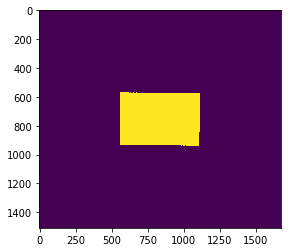

In [10]:
#visualize each terminus box rasters by BoxID
termplot = plt.imshow(termboxes['Helheim'])
plt.show()

### Find x,y coordinates of box vertices and midpoints of left and right edges to get the centerline

    1) Left side
        1A) Top Left (lowest x*y)
        1B) Bottom Left (highest y/x)
        1C) Midpoint of 1A and 1B:
$\dfrac{x_{1}+x_{2}}{2}$ , $\dfrac{y_{1}+y_{2}}{2}$

    2) Right side
        2A) Top Right (highest y/x)
        2B) Bottom Right (highest x*y)
        2C) Midpoint of 2A and 2B.
        
    3) Centerline equation

Calculate the equation for the centerline (slope between the two midpoints). Just need to calculate slope: $m =\dfrac{y_{2}-y_{1}}{x_{2}-x_{1}}$

and solve for the intercept using one of the midpoint coordinate pairs: $b = y - mx$

$y = mx + b$

In [12]:
#create dictionary to store the all coordinates of the box rasters
boxes_xcoords = {}
boxes_ycoords = {}

#create dictionaries for the box vertices
topleft_coords = {}
bottomleft_coords = {}
topright_coords = {}
bottomright_coords = {}

#create dictionaries to store the left midpoints (1C) and right midpoints (2C)
midpoints_x = {}
midpoints_y = {}
midpoints_r_x = {}
midpoints_r_y = {}

#create dictionaries to the slopes and intercepts of the centerline equations
slopes = {}
intercepts = {}

#for all the box rasters
for BoxID in BoxIDs:
    #Read in the raster of the BoxID of interest
    BOI = termboxes[BoxID]
    
    #find the coordinates of where the pixel value is nonzero (where the box exists)
    yindices, xindices = np.where(BOI > 0)

    #add box coordinates to the dictionary
    boxes_ycoords.update( {BoxID: yindices})
    boxes_xcoords.update( {BoxID: xindices})
    
    
    #1A) FIND THE TOP LEFT COORDINATES (lowest x*y)
    xy = xindices*yindices
    #Find the lowest xy value
    min_xy = np.min(xy)
    #Find the x and y pair corresponding to that xy using the index
    min_xy_i = np.where(xy == min_xy)[0][0]
    topleft = [xindices[min_xy_i], yindices[min_xy_i]]
#     print("Top left", topleft)
    #Add to dictionary of topleft coordinates
    topleft_coords.update(  {BoxID: topleft}  )
    
    #2B) FIND THE BOTTOM RIGHT COORDINATES (highest x*y)
    max_xy = np.max(xy)
    max_xy_i = np.where(xy == max_xy)[0][0]
    bottomright = [xindices[max_xy_i], yindices[max_xy_i]]
    bottomright_coords.update( {BoxID: bottomright})

    #1B) FIND THE BOTTOM LEFT COORDINATE(highest y/x)
    y_x = yindices/xindices
    #Find the highest y/x value
    max_y_x = np.max(y_x)
    #Find the x and y pair corresponding to that y/x using the index
    max_y_x_i = np.where(y_x == max_y_x)[0][0]
    bottomleft = [xindices[max_y_x_i], yindices[max_y_x_i]]
#     print("Bottom left", bottomleft)
    #Add to dictionary of bottomleft coordinates
    bottomleft_coords.update( {BoxID: bottomleft}  )
    
    #2A) FIND THE TOP RIGHT COORDINATES (highest x/y)
    x_y = xindices/yindices
    #find highest x/y value:
    max_x_y = np.max(x_y)
    #Find the x, y pair correpsonding to the maximum x/y using the index
    max_x_y_i = np.where(x_y == max_x_y)[0][0]
    topright = [xindices[max_x_y_i], yindices[max_x_y_i]]
    topright_coords.update( {BoxID: topright} )
    
    #1C and 2C) CALCULATE THE MIDPOINTS
    #Left
    midpoint_x = (topleft[0]+bottomleft[0])/2
    midpoint_y = (topleft[1]+bottomleft[1])/2  
    #Right
    midpoint_r_x = (topright[0]+bottomright[0])/2
    midpoint_r_y = (topright[1]+bottomright[1])/2
    
    #midpoint = [midpoint_x, midpoint_y]
    #Add x and y coordinates to dictionaries
    midpoints_x.update( {BoxID: midpoint_x}  )
    midpoints_y.update( {BoxID: midpoint_y}  )
    midpoints_r_x.update( {BoxID: midpoint_r_x})
    midpoints_r_y.update( {BoxID: midpoint_r_y})
    
    #3) CALCULATE CENTERLINE EQUATION
    #slope
    m = (midpoint_r_y - midpoint_y)/(midpoint_r_x - midpoint_x)
    #y-intercept
    b = midpoint_y - (m*midpoint_x)
#     print("y =", m, "x +", b)
    
    #add slope and intercepts to dictionaries
    slopes.update( {BoxID: m})
    intercepts.update( {BoxID: b})

### Visual check of the vertices, midpoints, and centerlines by plotting over terminus box:

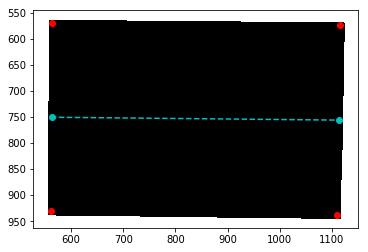

In [16]:
#Choose which glacier BoxID to check:
BOI_ID = 'Helheim'

#plot the raster pixels in black
plt.scatter(boxes_xcoords[BOI_ID], boxes_ycoords[BOI_ID], c='k',marker='s')

#plot the vertices in red
plt.scatter(topleft_coords[BOI_ID][0], topleft_coords[BOI_ID][1], c='r')
plt.scatter(bottomleft_coords[BOI_ID][0], bottomleft_coords[BOI_ID][1], c='r')
plt.scatter(topright_coords[BOI_ID][0], topright_coords[BOI_ID][1], c='r')
plt.scatter(bottomright_coords[BOI_ID][0], bottomright_coords[BOI_ID][1], c='r')

#plot midpoints in cyan
plt.scatter(midpoints_x[BOI_ID], midpoints_y[BOI_ID], c='c')
plt.scatter(midpoints_r_x[BOI_ID], midpoints_r_y[BOI_ID], c='c')

#plot the centerlines in blue
x=np.linspace(np.min(boxes_xcoords[BOI_ID]), np.max(boxes_xcoords[BOI_ID]))
y=slopes[BOI_ID]*x + intercepts[BOI_ID]
plt.plot(x, y, '--c')
         
plt.gca().invert_yaxis()
plt.axis('scaled')
plt.show()

### Turn the dictionaries storing the coordinates and centerlines into DataFrames and concatenate together

In [18]:
midpoints_x_df = pd.DataFrame.from_dict(midpoints_x, orient='index', columns=["midpoint_x"])
midpoints_y_df = pd.DataFrame.from_dict(midpoints_y, orient='index', columns=['midpoint_y'])

cline_slopes_df = pd.DataFrame.from_dict(slopes, orient='index', columns=["cline_slope"])
cline_intercepts_df = pd.DataFrame.from_dict(intercepts, orient='index', columns=["cline_intercept"])

total_df = pd.concat([midpoints_x_df, midpoints_y_df, cline_slopes_df, cline_intercepts_df], axis=1)
total_df.index.name = 'BoxID'
total_df

,midpoint_x,midpoint_y,cline_slope,cline_intercept
BoxID,,,,
Alison,547.5,711.5,0.081081,667.108108
Helheim,562.5,750.5,0.009991,744.880109


#### Export to Boxes_coords_pathrows.csv

In [19]:
total_df.to_csv(path_or_buf = basepath+'Boxes_coords_pathrows_AH.csv', sep=',')